# Part 1 - Cross Validation



Calculate the train/test (20%) errors on a random sampling of the train and test using kfold:

In [2]:
import pandas as pd
import numpy as np
import copy
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
pd.options.mode.chained_assignment = None
df_train_org = pd.read_csv('train.csv',parse_dates=['timestamp'])
df_test_org = pd.read_csv('test.csv',parse_dates=['timestamp'])
df_train = copy.deepcopy(df_train_org)
df_test=copy.deepcopy(df_test_org)

<AxesSubplot:>

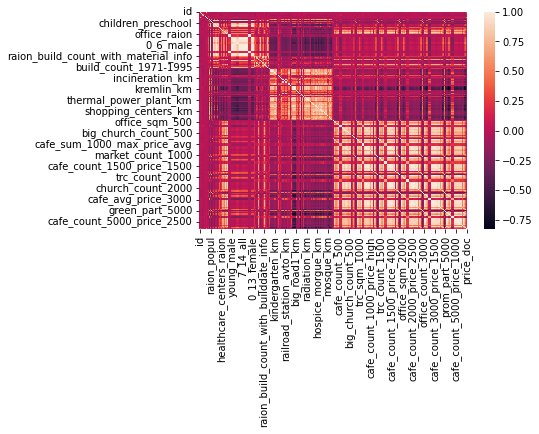

In [3]:
# Get summary statistics of numerical variables
df_train.describe()

# Check for missing values
df_train.isnull().sum()

# Visualize the distribution of the target variable
import seaborn as sns
sns.histplot(df_train['price_doc'], kde=False)

# Visualize the correlation between numerical variables
sns.heatmap(df_train.corr())

In [4]:
from sklearn import  preprocessing
from sklearn.impute import SimpleImputer
import copy

## Some preproccessing:

# Remove outliers
df_train = df_train[df_train.price_doc / df_train.full_sq <= 600000]
df_train.loc[df_train['build_year'] > 2018, 'build_year'] = np.nan
df_train.loc[df_train['build_year'] < 1000, 'build_year'] = np.nan


df_train.loc[:, 'timestamp'] = pd.to_datetime(df_train['timestamp'])
df_train.loc[:, 'year_stamp'] = df_train['timestamp'].dt.year 
df_train.loc[:, 'month_stamp'] = df_train['timestamp'].dt.month
df_train.loc[:, 'day_stamp'] = df_train['timestamp'].dt.day

#drop 'timestamp' column
df_train.drop('timestamp', axis=1, inplace=True)

# same for test set
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_test['year_stamp'] = df_test['timestamp'].dt.year 
df_test['month_stamp'] = df_test['timestamp'].dt.month
df_test['day_stamp'] = df_test['timestamp'].dt.day

#drop 'timestamp' column
df_test.drop('timestamp', axis=1, inplace=True)

#Converting continuous variables into limited bins bases on quantiles
from sklearn.preprocessing import KBinsDiscretizer

features_to_bin = ["industrial_km", "big_market_km", "market_shop_km", "church_synagogue_km", "incineration_km", "big_road1_km", "bus_terminal_avto_km", "mosque_km"]
binned_features = []
def binning():
    global binned_features
    for feature in features_to_bin:
        binf = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
        binf = binf.fit(df_train[feature].values.reshape(-1,1))#.astype(int)
        df_train[f"{feature}_bin"] = binf.transform(df_train[feature].values.reshape(-1,1)).astype(int)
        df_test[f"{feature}_bin"] = binf.transform(df_test[feature].values.reshape(-1,1)).astype(int)
        binned_features.append(f"{feature}_bin")         
binning()


# Convert categorical variables to numerical
for c in df_train.columns:
    if df_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_train[c].values)) 
        df_train[c] = lbl.transform(list(df_train[c].values))

for c in df_test.columns:
    if df_test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_test[c].values)) 
        df_test[c] = lbl.transform(list(df_test[c].values))
    

df_train = df_train.fillna(df_train.select_dtypes(include=np.number).mean())
df_test = df_test.fillna(df_test.select_dtypes(include=np.number).mean())

# Split the data into features and target variable
X = df_train.drop(['price_doc', 'id'], axis=1)
y = df_train['price_doc']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# Train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Calculate the train error
y_train_pred = rf.predict(X_train)
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Calculate the test error using k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
test_errors = []
for train_index, test_index in kf.split(X_test):
    X_train_kf, X_test_kf = X_test.iloc[train_index], X_test.iloc[test_index]
    y_train_kf, y_test_kf = y_test.iloc[train_index], y_test.iloc[test_index]
    y_test_pred_kf = rf.predict(X_test_kf)
    test_error_kf = np.sqrt(mean_squared_error(y_test_kf, y_test_pred_kf))
    test_errors.append(test_error_kf)

test_error = np.mean(test_errors)
print(f'Train error: {train_error}')
print(f'Test error: {test_error}')


Train error: 1011605.0518563299
Test error: 2554929.8771617506


Now use the same model and split the train/ test when by the time of the sale:

In [6]:
df_train.sort_values(by='year_stamp', inplace=True)
# Get the index for the split point
split_index = int(0.8 * len(df_train))

# Split the data into training and testing sets based on time
train = df_train.iloc[:split_index, :]
test = df_train.iloc[split_index:, :]

# Split the training and testing sets into features and target variable
X_train = train.drop(['id', 'year_stamp','month_stamp', 'day_stamp', 'price_doc'], axis=1)
y_train = train['price_doc']
X_test = test.drop(['id', 'year_stamp','month_stamp', 'day_stamp', 'price_doc'], axis=1)
y_test = test['price_doc']

# Train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Calculate the train error
y_train_pred = rf.predict(X_train)
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Calculate the test error
y_test_pred = rf.predict(X_test)
test_error = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'Train error: {train_error}')
print(f'Test error: {test_error}')

Train error: 981315.5114463305
Test error: 3025886.6139713777


The two results are likely to be different due to the differences in the way the train and test sets are split.
time-based split is a more realistic representation of how the model will perform on new, unseen data. The k-fold cross-validation, on the other hand, gives an estimate of the model's generalization performance but may not reflect the model's performance on unseen data.

In the first split, we randomly split the data into training and testing sets, using the train_test_split. This can lead to different subsets of data being used for training and testing in each iteration of k-fold cross-validation. Therefore, the test error can vary depending on the random seed used for the split, and also on the number of iterations used in k-fold cross-validation.

In the second split, we split the data based on time, using the first 80% of the data for training and the last 20% of the data for testing. This ensures that the model is trained on data that comes before the test data in time, which is a more realistic scenario in practice. Therefore, the test error obtained from this approach is likely to be more reliable for assessing the model's performance on new data.


# Part 2 - Classification

Choosing a sub-area from the top 10 sub-areas, then I built a model to calculate the price per sqr meter and divide to 4 percentiles, use each of these percentiles as a label.
Once it's done created a Random Forest classifier to predict the class label, and calculated the confusion matrix and precision-recall for each of the categories.

In [7]:
from sklearn.ensemble import RandomForestClassifier
import copy
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

df_train = pd.read_csv('train.csv')

top_10_subareas = df_train['sub_area'].value_counts().head(10).index.tolist() # finding top 10 subareas

sub_area = 'Tverskoe'  # Choose a sub-area from the top 10, I chose Tverskoe but the code can fit any other sub-area

# Calculate the price per sqm for the entire dataframe
df_train['price_per_sqm'] = df_train['price_doc'] / df_train['full_sq']

# Filter out the rows corresponding to the chosen sub-area and create a new dataframe
df_subarea = df_train.loc[df_train['sub_area'] == sub_area].copy()

# Create labels based on price per sqm percentiles
df_subarea['price_label'] = pd.qcut(df_subarea['price_per_sqm'], q=4, labels=['L1', 'L2', 'L3', 'L4'])

# Split the data into features and target variable
X = df_subarea.drop(['id', 'timestamp', 'sub_area', 'price_doc', 'price_per_sqm', 'price_label'], axis=1)
y = df_subarea['price_label']

# Convert categorical variables to numerical
for c in X.columns:
    if X[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X[c].values)) 
        X[c] = lbl.transform(list(X[c].values))

X = X.fillna(df_train.select_dtypes(include=np.number).mean()) # Fill nulls with mean

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = rf.predict(X_test)

# Calculate the confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
conf = pd.DataFrame(confusion_matrix)
# Calculate the precision-recall for each category
report = classification_report(y_test, y_pred)

print(report)
print(conf)

              precision    recall  f1-score   support

          L1       0.64      0.66      0.65        38
          L2       0.43      0.46      0.44        35
          L3       0.43      0.44      0.43        34
          L4       0.72      0.62      0.67        29

    accuracy                           0.54       136
   macro avg       0.56      0.54      0.55       136
weighted avg       0.55      0.54      0.55       136

Predicted  L1  L2  L3  L4
Actual                   
L1         25   8   4   1
L2         10  16   8   1
L3          2  12  15   5
L4          2   1   8  18
